In [1]:
###############################################################################
#                          Libraries to use
###############################################################################

#########
#########
#########  Pyswarm package is from 2014.  Convert over to pyswarms, which has 
#########  active development.  This may help to improve convergence issues.
#########
#########


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import csv

#!pip install pyswarm
#!pip install lmfit
from pyswarm import pso
from lmfit import (Minimizer, minimize, Parameters, Parameter, report_fit, 
                   fit_report)
from scipy.integrate import odeint
from scipy import interpolate

In [2]:
## Note that pandas automatically outputs a dataframe a la R,
## only no slicing indexing allowed.  To do that, you must coerce
## to an array.

#data_url = 'https://raw.githubusercontent.com/alexbbrummer/car_T/master/cart_dex_mean_sd_gbm_single_line.csv'
data_url = "../data/pbt_second_round/car_T_dex_pbt3_pbt4_lines.csv"
data = pd.read_csv(data_url)

In [3]:
## Examine first five rows of data

data.head()

,Time (Hour),"Y(A1,A2)","SD(A1,A2)","Y(B1,B2)","SD(B1,B2)","Y(C1,C2)","SD(C1,C2)","Y(D1,D2)","SD(D1,D2)","Y(E1,E2)",...,"Y(D11,D12)","SD(D11,D12)","Y(E11,E12)","SD(E11,E12)","Y(F11,F12)","SD(F11,F12)","Y(G11,G12)","SD(G11,G12)","Y(H11,H12)","SD(H11,H12)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.0000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.005000,-0.00205,0.000495,-0.00015,0.000495,-0.00305,0.000071,-0.00310,0.000283,0.00030,...,-0.0008,0.000707,-0.00015,0.002899,-0.00170,0.001838,-0.00025,0.001344,-0.00070,0.001273
2,0.255278,-0.05530,0.002970,-0.04720,0.005374,-0.03325,0.006576,-0.02675,0.005869,-0.02235,...,-0.0115,0.001414,-0.00885,0.000354,-0.02335,0.003889,-0.02990,0.001980,-0.02225,0.015203
3,1.280278,0.04435,0.000636,0.02095,0.008415,0.00550,0.011314,-0.01465,0.014779,0.01630,...,0.0263,0.001697,0.03735,0.002475,0.03680,0.001980,0.05615,0.001485,0.10745,0.019728
4,1.530833,-0.03295,0.000495,-0.02390,0.007920,-0.01510,0.007212,-0.01515,0.018738,0.00110,...,0.0151,0.000283,0.02770,0.000707,0.01535,0.001626,0.01270,0.002263,0.03400,0.023759


In [4]:
###############################################################################
#                     ODE system Model writing
#       currently hardcoded for modeling with/without dex, without t cells
#     uses try/except to toggle use with lmfit (the try) or pyswarm (the
#     exception) and logicals to toggle for with and without dex:
#     (1) gradient along dex without t cell
###############################################################################

def f_growth(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
      # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        # Different if/elif conditions are for calling back to this function
        # at different future uses.
        if len(ps) == 2:
            rho, kappainv = ps
            c0 = 0
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 3:
            rho, kappainv, c0 = ps
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 1:
            c0 = ps
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_growth(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_growth, x0, t, args=(ps, t_start))
    return x

def rms_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    return ((model[:,0] - data)/sigma).ravel()

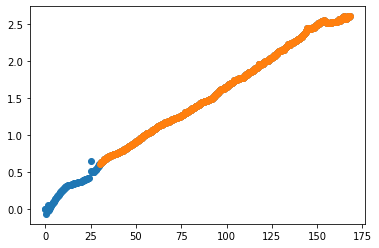

In [5]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Define data to be used.
#     User must specify start, end, column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_0 = 115
end_0 = 666
data_column_0 = 'Y(H1,H2)'
sigma_column_0 = 'SD(H1,H2)'
dex_0 = 0
tumor_line = 'PBT4'

data_full = np.array(data[['Time (Hour)', data_column_0]])
data_fit = np.array(data[['Time (Hour)', data_column_0]])[start_0:end_0,:]
data_sigma = np.array(data[['Time (Hour)', sigma_column_0]])[start_0:end_0,:]

t_cell_start_0 = 0.0

t = data_fit[:,0]

####### Your definition of x0 is for the initial populations,
## not the derivatives of the initial populations.
## Fix x0 definition to call on ode function to return dx/dt_0
#######
x0 = np.array([data_fit[0,1],t_cell_start_0])

plt.plot(data_full[:,0], data_full[:,1], 'o')
plt.plot(t, data_fit[:,1],'o')
plt.show()

Stopping search: Swarm best objective change less than 1e-08
[0.02242548 0.32410448] 0.3537088876729594


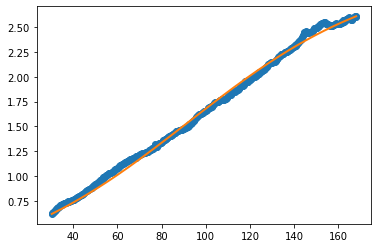

In [6]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds. 
###############################################################################

# arguments are initial values of tumor cell index and t cell count,
# time domain, measured cell index values
args = (x0, t, data_fit[:,1], data_sigma[:,1])

# manually specifying lower and upper bounds, 
# range identified by trial and error.
lb = [0,0]
ub = [1,2]

#lb = [0., 0., -10]
#ub = [1., 1., 10]

# run pso() as particle swarm optimization
xopt, fopt = pso(rms_growth, lb, ub, args = args)
print(xopt, fopt)

# plot data and fitted curves
prediction = g_growth(t, x0, xopt)
plt.plot(t, data_fit[:,1], 'o')
plt.plot(t, prediction[:,0], '-', linewidth=2)
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 551
    # variables        = 2
    chi-square         = 68.9355962
    reduced chi-square = 0.12556575
    Akaike info crit   = -1141.28773
    Bayesian info crit = -1132.66426
[[Variables]]
    rho:       0.02242587 +/- 1.2951e-04 (0.58%) (init = 0.02242548)
    kappainv:  0.32411054 +/- 0.00219999 (0.68%) (init = 0.3241045)
    c0:        0 (fixed)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.950


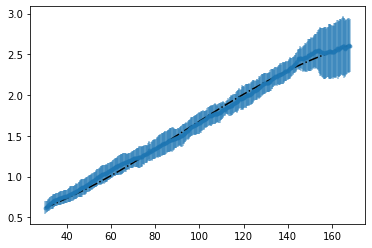

In [7]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#               Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

params = Parameters()
# the .tolist() method is to convert the np.float64 dtype pso output into a float
# that will work with the function call to f(xs, t, ps)
params.add('rho', value=xopt[0], min=lb[0], max=ub[0], vary = True)  
params.add('kappainv', value=xopt[1], min=lb[1], max=ub[1], vary = True)
params.add('c0', value=0.0, min=-100, max=100, vary = False)
params.add('kappac1', value=0.0, min=0.0, max=40, vary = False)
params.add('kappac2', value=0.0, min=0.0, max=10, vary = False)
params.add('theta', value=0.0, min=0.0, max=10, vary = False)
params.add('c3', value=0.0, min=0.0, max=10, vary = False)

result_growth = minimize(residual_growth, params, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
final = data_fit[:,1] + result_growth.residual.reshape(data_fit[:,1].shape)
prediction = g_growth(t, x0, result_growth.params)

# Print report of fit.
print(fit_report(result_growth))
# plot data and fitted curves
plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.5)
#plt.plot(t, data_fit[:,1], 'o')
plt.plot(t, prediction[:,0], 'k-.')
#plt.plot(t, final, '-', linewidth=2)
plt.show()

In [8]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_interaction(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            c0 = result_growth.params['c0'].value
            c3 = result_growth.params['c3'].value
            kappac1, kappac2, theta = ps
        elif len(ps) == 5:
            c0 = result_growth.params['c0'].value
            c3 = result_growth.params['c3'].value
            rho, kappainv, kappac1, kappac2, theta = ps
        elif len(ps) == 7:
            rho, kappainv, kappac1, c0, kappac2, theta, c3 = ps

    x, y = xs

    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_interaction, x0, t, args=(ps,t_start))
    return x

def rms_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms

#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.05*(t-t_start)**2))+1

def residual_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
#    weights = weight_fun(ts, 50, ts[0])
#    weights = weights/np.max(weights)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

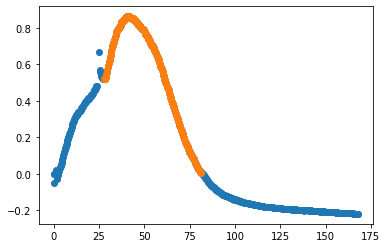

0.00595


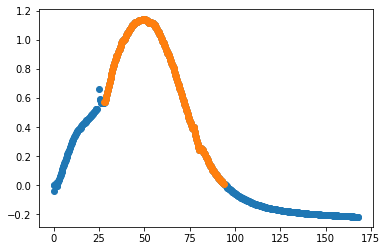

0.01005


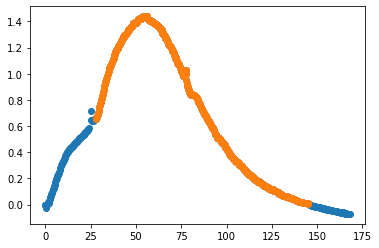

0.00415


In [9]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     CAR T cell treatment only:
#                     Re-define data to be used
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################


start_t = [105, 105, 105]
end_t = [320, 370, 575]
data_column_t = ['Y(G1,G2)', 'Y(F1,F2)', 'Y(E1,E2)']
sigma_column_t = ['SD(G1,G2)', 'SD(F1,F2)', 'SD(E1,E2)']
t_cell_start_t = [0.25, 0.125, 0.05]
dex_start_t = [0, 0, 0]

for i in range(0,3):

    data_full = np.array(data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

In [10]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt = []
t_fin_vec = [0.64575, 0.24335, 0.099]

for i in range(0,3):
    
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some

    #lb = [1e-6, -1e0, -1e3]
    #ub = [1e-4, 1e0, 1e3]
#    lb = np.array([[1e-3, 1e-3, 1e-3], [1e-3, 1e-3, 1e-3], [1e-3, 1e-3, 1e-3]])
#    ub = np.array([[1e-1, 5e0, 1e0], [1e-1, 5e0, 1e0], [1e-1, 1e0, 1e0]])
    ub = np.array([[1e0, 5e0, 1e0, 1e-1, 1e-4], [1e0, 5e0, 1e0, 1e-1, 1e-4],[1e0, 5e0, 1e0, 1e-1, 1e-4]])
    lb = np.array([[1e-1, 1e-4, 1e-1, 1e-2, 1e-7], [1e-2, 1e-3, 1e-1, 1e-2, 1e-7],[1e-1, 1e-3, 1e-1, 1e-2, 1e-7]])
    
    # run pso() as particle swarm optimization #  minfunc=1e-10, minstep=1e-10,
    xopt_temp, fopt = pso(rms_tcell, lb[i], ub[i], args = args, maxiter=1000, 
                          phig= 1, phip= 2, omega = 0.7, swarmsize=50)
    xopt.append(xopt_temp)
    print(xopt[i], fopt)

    # plot data and fitted curves
    prediction = g(t, x0, xopt[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.plot(t, prediction[:,1], '-.', linewidth=2)
    plt.plot(t[0], t_cell_start_t[i], 'rx')
    plt.plot(t[-1], t_fin, 'rx')
    plt.show()
    



KeyboardInterrupt: 

In [11]:
#xopt[0] = xopt[1]
#xopt[2] = xopt[1]
#xopt_copy = xopt.copy

#xopt[0][4] = xopt[1][4]
#xopt[1][1] = xopt[0][1]
#xopt[2][4] = xopt[1][4]

xopt = np.array([[0.17654640, 0.14787426, 0.41619017, 0.03234807, 1.9467e-07],
                 [0.23890378, 0.01172510, 1.44379975, 0.01277164, 3.7235e-07],
                 [0.25569045, 0.18110085, 2.94093818, 0.01000030, 6.4691e-05]])
#xopt[0][1] = xopt[2][1]
#xopt[1][1] = xopt[2][1]
#xopt[2][2] = xopt[1][2]
#xopt[1] = [1,0.03,1e-11]
#xopt[2] = [0.4,0.03,1e-11]
lb = xopt - xopt*0.5
ub = xopt + xopt*0.5


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 425
    # data points      = 548
    # variables        = 5
    chi-square         = 1843.22737
    reduced chi-square = 3.39452554
    Akaike info crit   = 674.722922
    Bayesian info crit = 696.254298
[[Variables]]
    rho:       0.18451500 +/- 0.05170093 (28.02%) (init = 0.1765464)
    kappainv:  0.07393713 +/- 0.04487768 (60.70%) (init = 0.1478743)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   0.41769836 +/- 0.19921633 (47.69%) (init = 0.4161902)
    kappac2:   0.03914605 +/- 0.01636741 (41.81%) (init = 0.03234807)
    theta:     9.7352e-08 +/- 0.00305637 (3139513.59%) (init = 1.9467e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, kappac2)  = -0.999
    C(kappac2, theta)    =  0.994
    C(rho, kappac1)      =  0.993
    C(kappac1, theta)    = -0.990
    C(rho, kappac2)      = -0.988
    C(rho, theta)        = -0.982
    C(kappainv, kappac2) =  0.740
    C(kapp

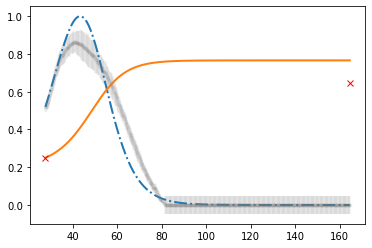

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12000
    # data points      = 548
    # variables        = 5
    chi-square         = 24807.2278
    reduced chi-square = 45.6855024
    Akaike info crit   = 2099.31304
    Bayesian info crit = 2120.84442
##  Warning: uncertainties could not be estimated:
    kappainv:  at boundary
    theta:     at boundary
[[Variables]]
    rho:       0.23365097 (init = 0.2389038)
    kappainv:  0.00586255 (init = 0.0117251)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   1.44754078 (init = 1.4438)
    kappac2:   0.01185340 (init = 0.01277164)
    theta:     1.8648e-07 (init = 3.7235e-07)


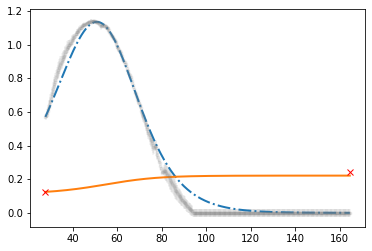

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2218
    # data points      = 548
    # variables        = 5
    chi-square         = 817.231599
    reduced chi-square = 1.50503057
    Akaike info crit   = 229.006689
    Bayesian info crit = 250.538065
[[Variables]]
    rho:       0.24105073 +/- 0.05370226 (22.28%) (init = 0.2556905)
    kappainv:  0.16453678 +/- 0.04476774 (27.21%) (init = 0.1811009)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   3.04409013 +/- 1.10415597 (36.27%) (init = 2.940938)
    kappac2:   0.00659760 +/- 0.00192140 (29.12%) (init = 0.0100003)
    theta:     3.2346e-05 +/- 5.9817e-06 (18.49%) (init = 6.4691e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappac1)      =  1.000
    C(rho, kappac2)      = -0.999
    C(kappac1, kappac2)  = -0.999
    C(kappainv, kappac1) = -0.998
    C(rho, kappainv)     = -0.996
    C(kappainv, kappac2) =  0.993
    C(kappac2, theta)    = -0.939
    C(rho, theta

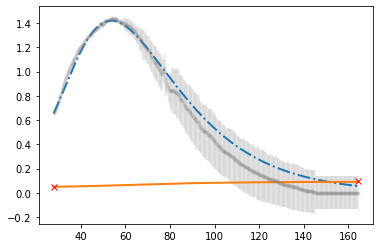

In [12]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

start_t = [105, 105, 105]
end_t = [320, 370, 575]

result_tcell = []

for i in range(0,3):
    

    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    params0 = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    #params0.add('rho', value=result_growth.params['rho'], min=0.0, max=1, vary = True)  
    #params0.add('kappainv', value=result_growth.params['kappainv'], min=0.01, max=2, vary = True)
    params0.add('rho', value=xopt[i][0], min=lb[i][0], max=ub[i][0], vary = True)  
    params0.add('kappainv', value=xopt[i][1], min=lb[i][1], max=ub[i][1], vary = True)
    params0.add('c0', value=result_growth.params['c0'], min=-50, max=50, vary = False)
    params0.add('c3', value=result_growth.params['c3'], min=0, max=10, vary = False)
    params0.add('kappac1', value=xopt[i][2], min=lb[i][2], max=ub[i][2], vary = True)
    params0.add('kappac2', value=xopt[i][3], min=lb[i][3], max=ub[i][3], vary = True)
    params0.add('theta', value=xopt[i][4], min=lb[i][4], max=ub[i][4], vary = True)


    result_tcell_temp = minimize(residual_tcell, params0, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
    result_tcell.append(result_tcell_temp)
#    final = data_fit[:,1] + result_tcell[i].residual.reshape(data_fit[:,1].shape)
    prediction = g(t,x0,result_tcell[i].params)

    # Print report of fit.
    try:
        print(fit_report(result_tcell[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
#    plt.plot(t, final, '-', linewidth=2)
    plt.plot(t,prediction[:,0], '-.', linewidth = 2)
    plt.plot(t, prediction[:,1], '-', linewidth=2)
    plt.plot(t[-1], t_fin, 'rx')
    plt.plot(t[0], t_cell_start_t[i], 'rx')
    plt.show()

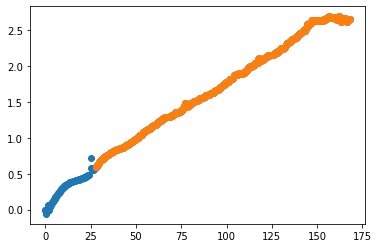

2.66075


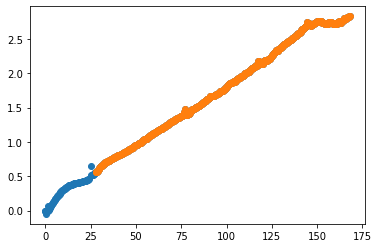

2.831


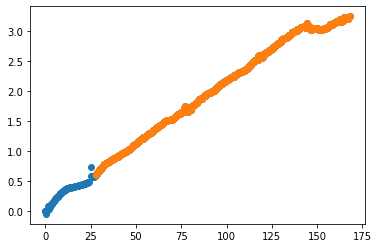

3.2458


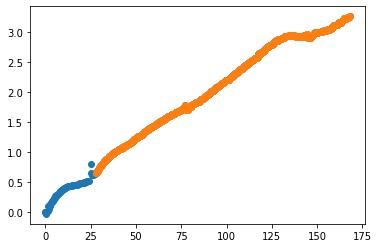

3.26985


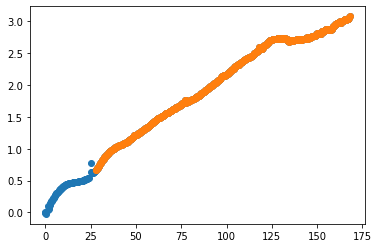

3.07725


In [13]:
###############################################################################
#                     Growth with Dex no T-cell
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_gd = [105, 105, 105, 105, 105]
end_gd = [666, 666, 666, 666, 666]
data_column_gd = ['Y(H3,H4)', 'Y(H5,H6)', 'Y(H7,H8)', 'Y(H9,H10)', 'Y(H11,H12)']
sigma_column_gd = ['SD(H3,H4)', 'SD(H5,H6)', 'SD(H7,H8)', 'SD(H9,H10)', 'SD(H11,H12)']
t_cell_start_gd = [0, 0, 0, 0, 0]
dex_start_gd = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]

for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

Stopping search: Swarm best objective change less than 1e-08
[-0.02465091] 19.618814363062356


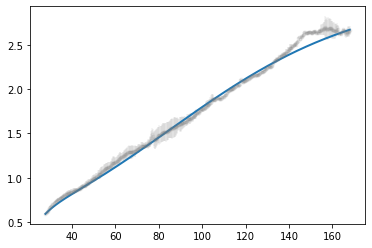

Stopping search: Swarm best objective change less than 1e-08
[-0.0595993] 21.484871014286274


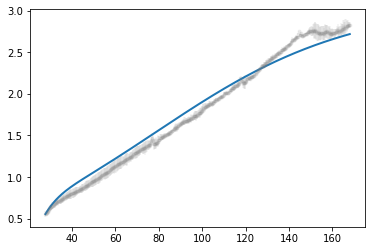

Stopping search: Swarm best objective change less than 1e-08
[-0.23766373] 25.114531362897154


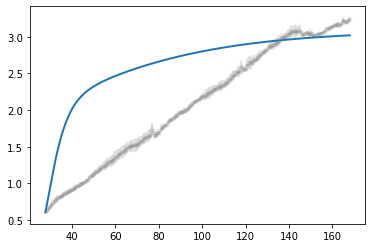

Stopping search: Swarm best objective change less than 1e-08
[-0.069331] 4.000285178073624


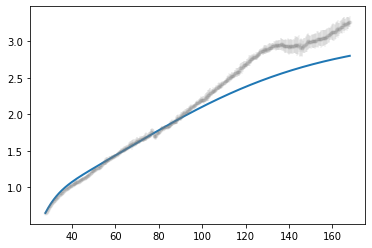

Stopping search: Swarm best objective change less than 1e-08
[-0.06369921] 2.610289957469986


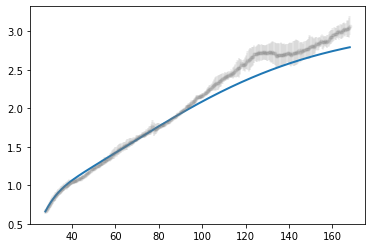

In [14]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_gd = []


for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some
    
    lb = np.array([[-100], [-100], [-100], [-100], [-100]])
    ub = np.array([[100], [100], [100], [100], [100]])
    #lb = np.array([[0., 0.], [0., 0.], [0., 0.]])
    #ub = np.array([[1., 1.], [1., 1.], [1., 1.]])
    #lb = np.array([[0., 0., -10], [0., 0., -10], [0., 0., -10]])
    #ub = np.array([[1., 1., 10], [1., 1., 10], [1., 1., 10]])
    
    # run pso() as particle swarm optimization
   
    xopt_temp, fopt = pso(rms_growth, lb[i], ub[i], args = args, maxiter=500, minfunc=1e-8, minstep=1e-8, phig=1.7, phip=0.6)
    xopt_gd.append(xopt_temp)
    print(xopt_gd[i], fopt)

    # plot data and fitted curves
    prediction = g_growth(t, x0, xopt_gd[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 561
    # variables        = 3
    chi-square         = 71930.8621
    reduced chi-square = 128.908355
    Akaike info crit   = 2728.94802
    Bayesian info crit = 2741.93718
[[Variables]]
    rho:       0.01744674 +/- 1.4623e-04 (0.84%) (init = 0.02242587)
    kappainv:  0.26430287 +/- 0.00242176 (0.92%) (init = 0.3241105)
    c0:       -0.05028729 +/- 9.6715e-04 (1.92%) (init = -0.02465091)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.923
    C(rho, c0)       =  0.780
    C(kappainv, c0)  =  0.495


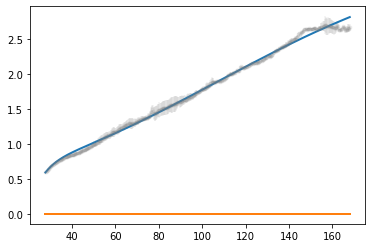

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 561
    # variables        = 3
    chi-square         = 8239.90799
    reduced chi-square = 14.7668602
    Akaike info crit   = 1513.42021
    Bayesian info crit = 1526.40937
[[Variables]]
    rho:       0.01734208 +/- 5.2042e-04 (3.00%) (init = 0.02242587)
    kappainv:  0.21387084 +/- 0.00629238 (2.94%) (init = 0.3241105)
    c0:       -0.04705747 +/- 0.00473084 (10.05%) (init = -0.0595993)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.996
    C(rho, kappainv) =  0.995
    C(kappainv, c0)  =  0.983


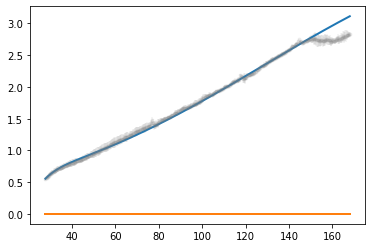

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 561
    # variables        = 3
    chi-square         = 2060.21322
    reduced chi-square = 3.69213839
    Akaike info crit   = 735.773403
    Bayesian info crit = 748.762566
[[Variables]]
    rho:       0.02527082 +/- 2.3814e-04 (0.94%) (init = 0.02242587)
    kappainv:  0.28002658 +/- 8.9090e-04 (0.32%) (init = 0.3241105)
    c0:       -0.03741854 +/- 0.00189275 (5.06%) (init = -0.2376637)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.967
    C(rho, c0)       =  0.902
    C(kappainv, c0)  =  0.767


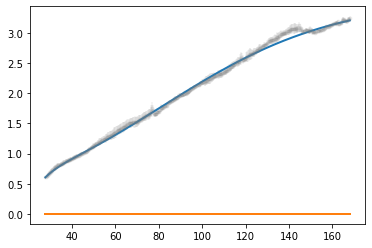

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 561
    # variables        = 3
    chi-square         = 726.695999
    reduced chi-square = 1.30232258
    Akaike info crit   = 151.179690
    Bayesian info crit = 164.168853
[[Variables]]
    rho:       0.02089210 +/- 1.6939e-04 (0.81%) (init = 0.02242587)
    kappainv:  0.25234514 +/- 0.00198979 (0.79%) (init = 0.3241105)
    c0:       -0.05983272 +/- 5.6814e-04 (0.95%) (init = -0.069331)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.941
    C(rho, c0)       =  0.855
    C(kappainv, c0)  =  0.696


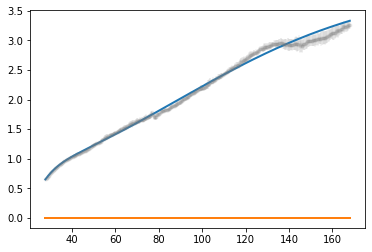

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 561
    # variables        = 3
    chi-square         = 997.365107
    reduced chi-square = 1.78739266
    Akaike info crit   = 328.797158
    Bayesian info crit = 341.786320
[[Variables]]
    rho:       0.02170717 +/- 2.2049e-04 (1.02%) (init = 0.02242587)
    kappainv:  0.27725984 +/- 0.00242332 (0.87%) (init = 0.3241105)
    c0:       -0.04834112 +/- 0.00115566 (2.39%) (init = -0.06369921)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.925
    C(rho, kappainv) =  0.910
    C(kappainv, c0)  =  0.686


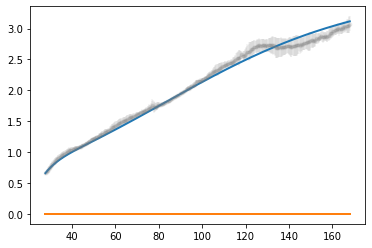

In [15]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_growth_gd = []

for i in range(0,5):
    
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    
    
    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    paramsgd = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    #paramsgd.add('rho', value=xopt_gd[i][0], min=lb[i][0], max=ub[i][0], vary = True)  
    #paramsgd.add('kappainv', value=xopt_gd[i][1], min=lb[i][0], max=ub[i][0], vary = True)
    paramsgd.add('rho', value=result_growth.params['rho'], min=0, max=1, vary = True)  
    paramsgd.add('kappainv', value=result_growth.params['kappainv'], min=0, max=2, vary = True)
    paramsgd.add('c0', value=xopt_gd[i][0], min=-100, max=100, vary = True)
    paramsgd.add('kappac1', value=0, min=-1, max=1, vary = False)
    paramsgd.add('kappac2', value=0, min=-1, max=1, vary = False)
    paramsgd.add('theta', value=0, min=-1, max=1, vary = False)
    paramsgd.add('c3', value=0, min=-1, max=1, vary = False)


    result_growth_gd_temp = minimize(residual_growth, paramsgd, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
    result_growth_gd.append(result_growth_gd_temp)
    final = data_fit[:,1] + result_growth_gd[i].residual.reshape(data_fit[:,1].shape)

    # Print report of fit.
    try:
        print(fit_report(result_growth_gd[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
    prediction = g_growth(t, x0, result_growth_gd[i].params)
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
    plt.plot(t, prediction, '-', linewidth=2)
#    plt.plot(t, final, '-', linewidth=2)
    plt.show()

In [16]:
###############################################################################
#                     T-cell with Dex
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            # define result_growth_gd_now variable within loop that
            # calls this block.
            rho = result_tcell_now.params['rho'].value
            kappainv = result_tcell_now.params['kappainv'].value
            c0 = result_growth_gd_now.params['c0'].value
            theta = result_tcell_now.params['theta'].value
            kappac1, kappac2, c3 = ps
        elif len(ps) == 7:
            rho, kappainv, c0, kappac1, kappac2, theta, c3 = ps

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_dt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps,t_start))
    return x

def rms_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms
#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.0005*(t-t_start)**2))+1

#def residual_dt(ps, *args):
#    x0, ts, data = args
#    model = g_dt(ts, x0, ps)
#    weights = weight_fun(ts, 1, ts[0])
#    weights = weights/np.max(weights)
#    return ((model[:,0] - data)*weights).ravel()

def residual_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

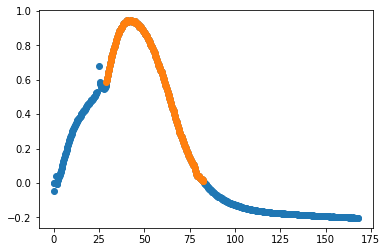

0.0093
DatasetY(G3,G4)


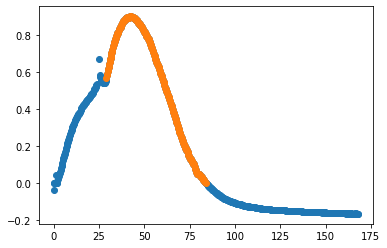

0.0022
DatasetY(G5,G6)


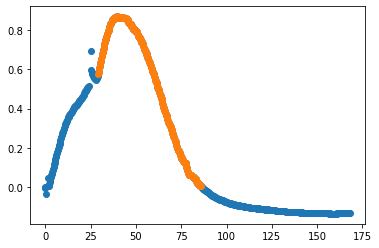

0.0031
DatasetY(G7,G8)


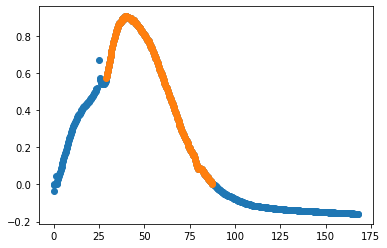

0.00485
DatasetY(G9,G10)


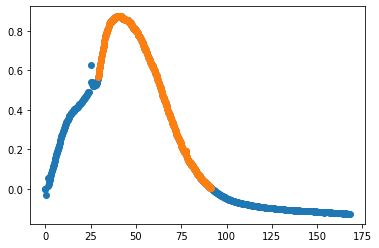

0.00125
DatasetY(G11,G12)


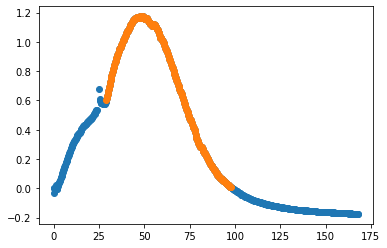

0.00845
DatasetY(F3,F4)


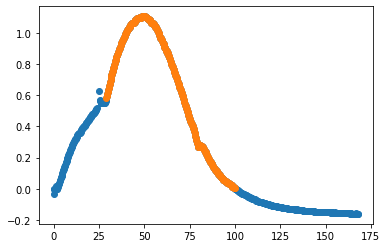

0.00315
DatasetY(F5,F6)


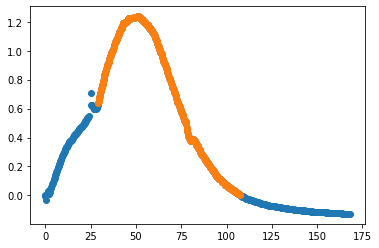

0.00245
DatasetY(F7,F8)


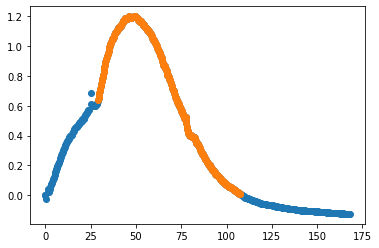

0.007
DatasetY(F9,F10)


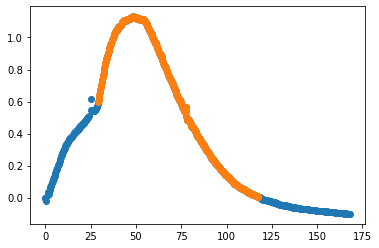

0.0021
DatasetY(F11,F12)


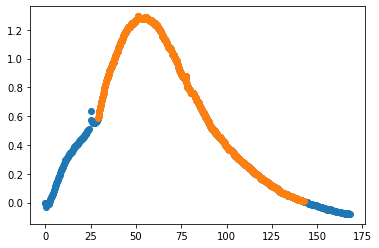

0.0086
DatasetY(E3,E4)


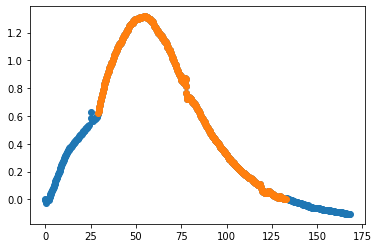

0.00595
DatasetY(E5,E6)


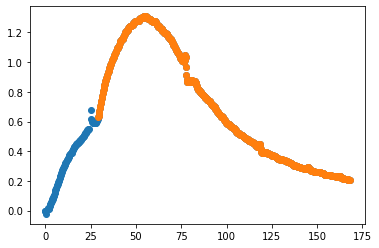

0.2041
DatasetY(E7,E8)


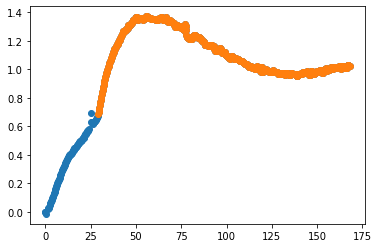

1.02035
DatasetY(E9,E10)


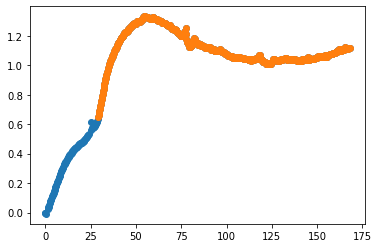

1.1157
DatasetY(E11,E12)


In [67]:
###############################################################################
#                     T-cell (0.25) with Dex
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

## Need to decide ordering of loops for grabbing data columns.

data_column_dt = ['Y(G3,G4)', 'Y(G5,G6)', 'Y(G7,G8)', 'Y(G9,G10)', 'Y(G11,G12)',
                 'Y(F3,F4)', 'Y(F5,F6)', 'Y(F7,F8)', 'Y(F9,F10)', 'Y(F11,F12)',
                 'Y(E3,E4)', 'Y(E5,E6)', 'Y(E7,E8)', 'Y(E9,E10)', 'Y(E11,E12)']
sigma_column_dt = ['SD(G3,G4)', 'SD(G5,G6)', 'SD(G7,G8)', 'SD(G9,G10)', 'SD(G11,G12)',
                 'SD(F3,F4)', 'SD(F5,F6)', 'SD(F7,F8)', 'SD(F9,F10)', 'SD(F11,F12)',
                 'SD(E3,E4)', 'SD(E5,E6)', 'SD(E7,E8)', 'SD(E9,E10)', 'SD(E11,E12)']

start_dt = [110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110]
end_dt = [325, 330, 338, 345, 360, 385, 394, 425, 425, 465, 565, 525, 666, 666, 666]
t_cell_start_dt = [0.25, 0.125, 0.05]
dex_start_dt = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
t_cell_fin_dt = [0.45055, 0.4802, 0.3291, 0.12035, 0.0647,
                 0.14025, 0.18635, 0.1558, 0.10765, 0.10915,
                 0.05495, 0.08115, 0.0855, 0.0917, 0.0375]

count = 0
for i in range(0,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]        

        t = data_fit[:,0]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        plt.plot(data_full[:,0], data_full[:,1], 'o')
        plt.plot(t, data_fit[:,1],'o')
        plt.show()
        print(data_fit[len(data_fit[:,1])-1,1])
        print("Dataset" + str(data_column_dt[count]))
        count = count + 1

# Here we break the final fittings into three group, one for each
# T-cell concentration.  Also, will try experimenting with using the
# best fit of five as the initial guess for all.

Stopping search: Swarm best objective change less than 1e-10
[0.59332685 0.02517716 0.03166996] 0.3601113169733709


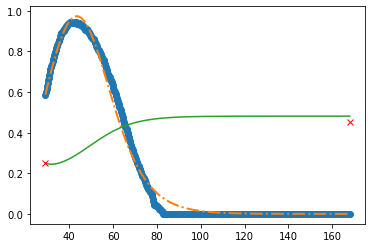

Stopping search: Swarm best objective change less than 1e-10
[0.91405857 0.035871   0.17234829] 1.9479739961574318


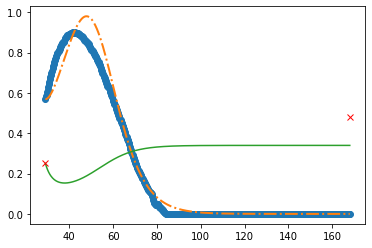

Stopping search: Swarm best objective change less than 1e-10
[2.77831488 0.0610173  0.51889592] 7.643706624288843


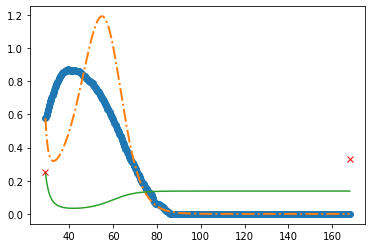

Stopping search: Swarm best objective change less than 1e-10
[ 0.5370868   0.02236592 -0.01899196] 2.9837571053746834


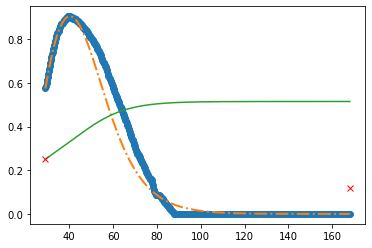

Stopping search: Swarm best objective change less than 1e-10
[0.88937014 0.02970837 0.13747277] 0.7001874784847273


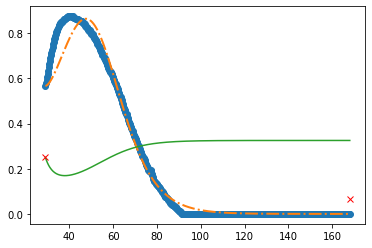

In [79]:
###############################################################################
#                     T-cell with Dex T-cell 1
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################


#    rho:       0.61203863 +/- 0.02834849 (4.63%) (init = 0.1821915)
#    kappainv:  0.31854979 +/- 0.07460323 (23.42%) (init = 0.139774)
#    c0:        0.32815551 +/- 0.04786970 (14.59%) (init = 0.1781848)
#    kappac1:   0.01803183 +/- 0.08475971 (470.06%) (init = 0.00147812)
#    kappac2:   0.04207642 +/- 0.00606276 (14.41%) (init = 0.01)
#    theta:     0.00234838 +/- 3.6048e-04 (15.35%) (init = 0.007896161)
#    c3:       -0.62702854 +/- 0.90580997 (144.46%) (init = -1.317145)


#    rho:       0.47477478 +/- 0.04347333 (9.16%) (init = 0.1785835)
#    kappainv:  0.30495567 +/- 0.28177964 (92.40%) (init = 0.144666)
#    c0:        0.23208979 +/- 0.09374913 (40.39%) (init = 0.1664343)
#    kappac1:   0.01319419 +/- 0.16413430 (1243.99%) (init = 0.01)
#    kappac2:   0.03155772 +/- 0.02345760 (74.33%) (init = 0.04045667)
#    theta:     1.0205e-04 +/- 5.1136e-04 (501.09%) (init = 0.007896161)
#    c3:       -0.73107647 +/- 2.34455215 (320.70%) (init = -0.6856248)

xopt_dt_01 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-1, 1e-3, -5e0], [1e-1, 1e-3, -5e0], [1e-1, 1e-3, -5e0], [1e-1, 1e-3, -5e0], [1e-1, 1e-3, -5e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[5e0, 5e-1, 5e0], [5e0, 5e-1, 5e0], [5e0, 5e-1, 5e0], [5e0, 5e-1, 5e0], [5e0, 5e-1, 5e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 0
for i in range(0,1):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[j]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=200, minfunc=1e-10, minstep=1e-10, phig=1.7, phip=0.6, swarmsize=100)
        xopt_dt_01.append(xopt_temp)
        print(xopt_dt_01[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [84]:
#xopt_dt_01[2] = xopt_dt_01[1]
#xopt_dt_01[0] = xopt_dt_01[3]
#xopt_dt_01[1] = xopt_dt_01[3]
xopt_dt_01[2] = xopt_dt_01[1]
#xopt_dt_01[4] = xopt_dt_01[3]
#xopt_dt_01[4] = xopt_dt_01[3]

#xopt_dt_01[0] = [0.51405773, 0.23425258, 1.25845284]
#xopt_dt_01[1] = [0.46402365, 0.22715446, 1.1226057]
#xopt_dt_01[2] = [0.46402365, 0.22715446, 1.1226057]
#xopt_dt_01[3] = [0.57844915, 0.19220776, 1.00701671]
#xopt_dt_01[4] = [0.57844915, 0.19220776, 1.00701671]
#xopt_dt_01

xopt_manual = np.array([[0.1765464, 0.1478743, -0.05517507, 0.59343880, 0.02923172, 1.0153e-08, 0.07199148],
                        [0.1765464, 0.1478743, -0.04620608, 0.55555902, 0.03000236, 1.0005e-08, 0.05133978],
                        [0.1765464, 0.1478743, -0.09679505, 0.78811614, 0.02776432, 1.0000e-08, 0.11457981],
                        [0.1765464, 0.1478743, -0.32936656, 1.89263188, 0.02043072, 1.0000e-08, 0.26921979],
                        [0.1765464, 0.1478743, -0.43905196, 2.58996889, 0.01812842, 1.0070e-08, 0.32458776]])

lb = xopt_manual*(0.5)
ub = xopt_manual*(1.5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 209
    # data points      = 557
    # variables        = 5
    chi-square         = 74.4874527
    reduced chi-square = 0.13494104
    Akaike info crit   = -1110.64754
    Bayesian info crit = -1089.03472
[[Variables]]
    rho:       0.1765464 (fixed)
    kappainv:  0.1478743 (fixed)
    c0:       -0.07864906 +/- 0.01886055 (23.98%) (init = -0.05517507)
    kappac1:   0.64426911 +/- 0.07840146 (12.17%) (init = 0.5934388)
    kappac2:   0.02920155 +/- 0.00201279 (6.89%) (init = 0.02923172)
    theta:     5.0766e-09 +/- 0.00152765 (30091846.52%) (init = 1.0153e-08)
    c3:        0.08361477 +/- 0.02396263 (28.66%) (init = 0.07199148)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.997
    C(c0, kappac1)      = -0.997
    C(kappac1, theta)   =  0.990
    C(c0, theta)        = -0.989
    C(c0, c3)           = -0.989
    C(theta, c3)        =  0.984
    C(kappac2, theta)   = -0.

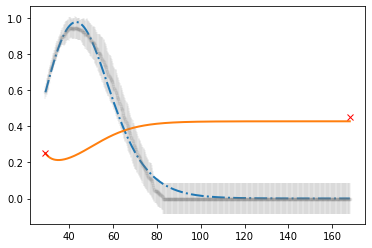

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2637
    # data points      = 557
    # variables        = 5
    chi-square         = 2573.12121
    reduced chi-square = 4.66145147
    Akaike info crit   = 862.382492
    Bayesian info crit = 883.995318
[[Variables]]
    rho:       0.1765464 (fixed)
    kappainv:  0.1478743 (fixed)
    c0:       -0.02310304 +/- 0.00745062 (32.25%) (init = -0.04620608)
    kappac1:   0.52085652 +/- 0.03345377 (6.42%) (init = 0.555559)
    kappac2:   0.03534923 +/- 0.00154530 (4.37%) (init = 0.03000236)
    theta:     5.5892e-09 +/- 7.5858e-04 (13572165.47%) (init = 1.0005e-08)
    c3:        0.07533808 +/- 0.01386290 (18.40%) (init = 0.05133978)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.963
    C(kappac2, theta)   =  0.888
    C(c0, kappac1)      = -0.778
    C(c0, kappac2)      =  0.728
    C(c0, theta)        =  0.639
    C(c0, c3)           = -0.618
    C(kappac1, theta)   = -0.541

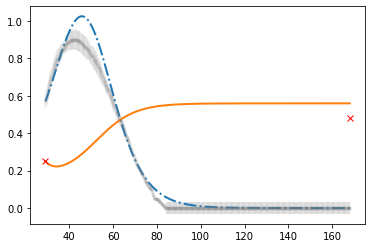

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12000
    # data points      = 557
    # variables        = 5
    chi-square         = 68218.3856
    reduced chi-square = 123.584032
    Akaike info crit   = 2688.00261
    Bayesian info crit = 2709.61544
##  Warning: uncertainties could not be estimated:
    theta:     at initial value
    theta:     at boundary
[[Variables]]
    rho:       0.1765464 (fixed)
    kappainv:  0.1478743 (fixed)
    c0:       -0.04989097 (init = -0.09679505)
    kappac1:   0.51716444 (init = 0.7881161)
    kappac2:   0.04090072 (init = 0.02776432)
    theta:     5.4118e-09 (init = 1e-08)
    c3:        0.14384757 (init = 0.1145798)


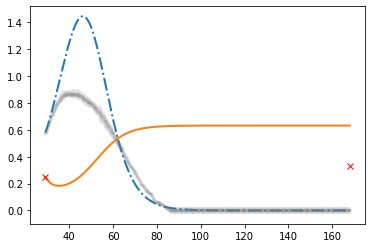

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12000
    # data points      = 557
    # variables        = 5
    chi-square         = 23572.0812
    reduced chi-square = 42.7030456
    Akaike info crit   = 2096.10595
    Bayesian info crit = 2117.71877
##  Warning: uncertainties could not be estimated:
    theta:     at initial value
    theta:     at boundary
[[Variables]]
    rho:       0.1765464 (fixed)
    kappainv:  0.1478743 (fixed)
    c0:       -0.30823491 (init = -0.3293666)
    kappac1:   1.57869812 (init = 1.892632)
    kappac2:   0.02323496 (init = 0.02043072)
    theta:     8.4885e-09 (init = 1e-08)
    c3:        0.21842861 (init = 0.2692198)


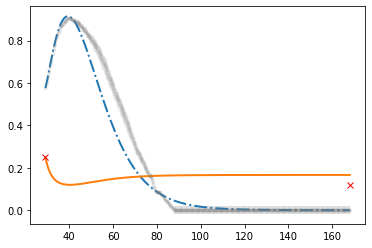

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 557
    # variables        = 5
    chi-square         = 56.0191465
    reduced chi-square = 0.10148396
    Akaike info crit   = -1269.35754
    Bayesian info crit = -1247.74471
[[Variables]]
    rho:       0.1765464 (fixed)
    kappainv:  0.1478743 (fixed)
    c0:       -0.34790713 +/- 0.03442333 (9.89%) (init = -0.439052)
    kappac1:   2.00508271 +/- 0.18227556 (9.09%) (init = 2.589969)
    kappac2:   0.02183738 +/- 0.00261178 (11.96%) (init = 0.01812842)
    theta:     5.1664e-09 +/- 9.0601e-04 (17536406.74%) (init = 1.007e-08)
    c3:        0.28428952 +/- 0.01407170 (4.95%) (init = 0.3245878)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, kappac1)      = -0.995
    C(kappac1, c3)      =  0.985
    C(kappac2, theta)   =  0.978
    C(c0, c3)           = -0.963
    C(c0, kappac2)      =  0.939
    C(kappac1, kappac2) = -0.915
    C(c0, theta)        =  0.906
   

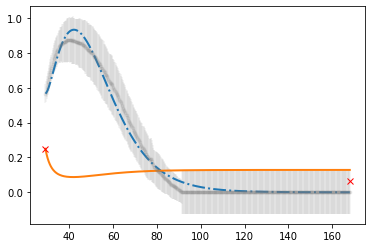

In [87]:
###############################################################################
#                     T-cell with Dex T cell 1
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_01 = []
#result_dt.pop(2)

count = 0

for i in range(0,1):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)
        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
#        paramsdt.add('rho', value=result_tcell[i].params['rho'], min=0.01, max=2, vary = False)  
#        paramsdt.add('kappainv', value=result_tcell[i].params['kappainv'], min=0.001, max=5, vary = False)
#        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-1e0, max=0, vary = True)
#        paramsdt.add('kappac1', value=xopt_dt_01[j][0], min=lb[count][0], max=ub[count][0], vary = True)
#        paramsdt.add('kappac2', value=xopt_dt_01[j][1], min=lb[count][1], max=ub[count][1], vary = True)
#        paramsdt.add('theta', value=result_tcell[i].params['theta'], min= 1e-8, max=1e0, vary = True)
#        paramsdt.add('c3', value=xopt_dt_01[count][2], min=lb[count][2], max=ub[count][2], vary = True)
        
        paramsdt.add('rho', value=xopt_manual[j][0], min=lb[j][0], max=ub[j][0], vary = False)  
        paramsdt.add('kappainv', value=xopt_manual[j][1], min=lb[j][1], max=ub[j][1], vary = False)
        paramsdt.add('c0', value=xopt_manual[j][2], min=lb[j][2], max=ub[j][2], vary = True)
        paramsdt.add('kappac1', value=xopt_manual[j][3], min=lb[j][3], max=ub[j][3], vary = True)
        paramsdt.add('kappac2', value=xopt_manual[j][4], min=lb[j][4], max=ub[j][4], vary = True)
        paramsdt.add('theta', value=xopt_manual[j][5], min=lb[j][5], max=ub[j][5], vary = True)
        paramsdt.add('c3', value=xopt_manual[j][6], min=lb[j][6], max=ub[j][6], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_01.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_01[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_01[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_01[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

#        plt.plot(t, data_fit[:,1], 'o')
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

In [30]:
## REDO THE LAST ROUND OF FITS USING THE MANUALLY SEARCHED VALUES SAVED IN 
## final_fit_guesses_carrgo_pbt1_cart_0.05.docx.  Then merge and write everything to file.

#result_dt_01_custom_values = np.array([[0.47477478, 0.30495567, 0.23208979, 0.01319419, 0.03155772, 1.0205e-04, -0.73107647],
#                                      [0.61219706, 0.31789160, 0.32854321, 0.01878507, 0.04202015, 0.00234879, -0.61915866],
#                                      [0.22459540, 0.30616102, 0.04064067, 0.00213993, 0.02469323, 0.00591645, -1.11796475],
#                                      [0.20241841, 0.24697910, 0.06449920, 0.00109203, 0.00823495, 0.00802364, -1.36044978],
#                                      [0.19786632, 0.21591065, 0.0815608, 5.0000e-04, 0.00126949, 0.00579529, -1.55583481]])

#result_dt_01_custom_values
print(result_dt_01[2].params)

Parameters([('rho', <Parameter 'rho', value=<Parameter 'rho', value=0.1845149957116315 +/- 0.0517, bounds=[0.0882732:0.2648196]> (fixed), bounds=[0.01:2]>), ('kappainv', <Parameter 'kappainv', value=<Parameter 'kappainv', value=0.07393713053125948 +/- 0.0449, bounds=[0.07393713:0.22181139]> (fixed), bounds=[0.001:5]>), ('c0', <Parameter 'c0', value=-0.03681366577820033, bounds=[-1.0:1.0]>), ('kappac1', <Parameter 'kappac1', value=0.9945815578977834, bounds=[0.1:5.0]>), ('kappac2', <Parameter 'kappac2', value=0.03825091081378056, bounds=[0.001:0.5]>), ('theta', <Parameter 'theta', value=1.1056759114083716e-08, bounds=[1e-08:1.0]>), ('c3', <Parameter 'c3', value=0.2005738681920466, bounds=[-5.0:5.0]>)])


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16000
    # data points      = 251
    # variables        = 7
    chi-square         = 4570009.92
    reduced chi-square = 18729.5489
    Akaike info crit   = 2476.20282
    Bayesian info crit = 2500.88099
##  Warning: uncertainties could not be estimated:
[[Variables]]
    rho:       0.46876929 (init = 0.4747748)
    kappainv:  0.42191383 (init = 0.3049557)
    c0:        0.27205154 (init = 0.2320898)
    kappac1:   0.02604608 (init = 0.01319419)
    kappac2:   0.02552450 (init = 0.03155772)
    theta:     0.00509950 (init = 0.00010205)
    c3:       -1.43858007 (init = -0.7310765)


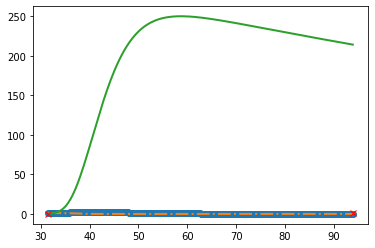

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16000
    # data points      = 261
    # variables        = 7
    chi-square         = 4239200.04
    reduced chi-square = 16689.7639
    Akaike info crit   = 2544.49020
    Bayesian info crit = 2569.44184
##  Warning: uncertainties could not be estimated:
[[Variables]]
    rho:       0.46876929 (init = 0.6121971)
    kappainv:  0.42191383 (init = 0.3178916)
    c0:        0.27204976 (init = 0.3285432)
    kappac1:   0.02617868 (init = 0.01878507)
    kappac2:   0.02552450 (init = 0.04202015)
    theta:     0.00509950 (init = 0.00234879)
    c3:       -1.43298675 (init = -0.6191587)


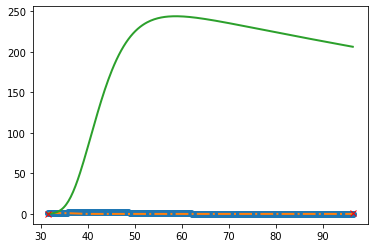

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16000
    # data points      = 533
    # variables        = 7
    chi-square         = 11133430.2
    reduced chi-square = 21166.2172
    Akaike info crit   = 5315.71979
    Bayesian info crit = 5345.66944
##  Warning: uncertainties could not be estimated:
[[Variables]]
    rho:       0.46876929 (init = 0.2245954)
    kappainv:  0.42191383 (init = 0.306161)
    c0:        0.27204894 (init = 0.04064067)
    kappac1:   0.02563136 (init = 0.00213993)
    kappac2:   0.02552460 (init = 0.02469323)
    theta:     0.00509950 (init = 0.00591645)
    c3:       -1.61277097 (init = -1.117965)


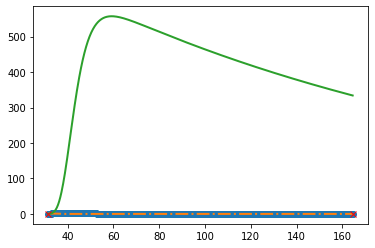

KeyboardInterrupt: 

In [279]:
###############################################################################
#                     T-cell with Dex T cell 1
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_01_new = []
#result_dt.pop(2)

count = 0

for i in range(0,1):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_dt_01_custom_values[j][0], min=8e-2, max=8e-1, vary = True)  
        paramsdt.add('kappainv', value=result_dt_01_custom_values[j][1], min=2e-1, max=5e-1, vary = True)
        paramsdt.add('c0', value=result_dt_01_custom_values[j][2], min=3e-2, max=5e-1, vary = True)
        paramsdt.add('kappac1', value=result_dt_01_custom_values[j][3], min=1e-4, max=5e-2, vary = True)
        paramsdt.add('kappac2', value=result_dt_01_custom_values[j][4], min=1e-3, max=5e-2, vary = True)
        paramsdt.add('theta', value=result_dt_01_custom_values[j][5], min=1e-4, max=1e-2, vary = True)
        paramsdt.add('c3', value=result_dt_01_custom_values[j][6], min=-2, max=-1e-1, vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin), method='leastsq')
        result_dt_01_new.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_01_new[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_01_new[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_01_new[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: maximum iterations reached --> 200
[1.71280149 0.01249066 0.04177896] 4.158151952745567


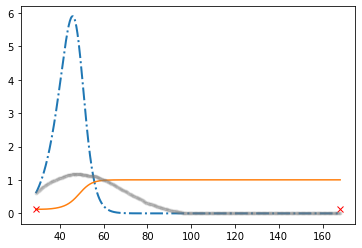

Stopping search: Swarm best objective change less than 1e-10
[2.34022083 0.01714034 0.12876757] 2.32232518745546


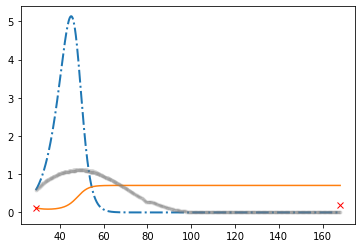

Stopping search: Swarm best objective change less than 1e-10
[5.         0.02608538 0.33453489] 2.606201998596914


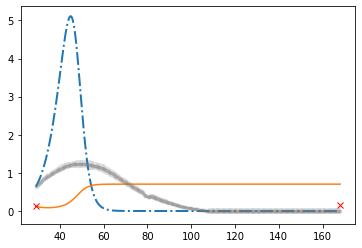

Stopping search: maximum iterations reached --> 200
[1.99902882 0.01031074 0.06128111] 5.500426259048502


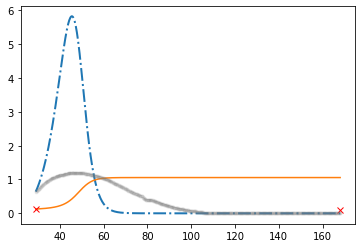

Stopping search: Swarm best objective change less than 1e-10
[ 1.45482061  0.00767148 -0.02167389] 0.2691502333653856


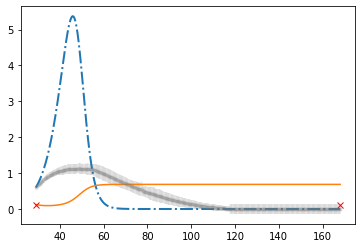

In [88]:
###############################################################################
#                     T-cell with Dex T-cell 2
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_02 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-3, 1e-3, -1e0], [1e-6, 1e-2, -1e0], [1e-6, 1e-3, -1e0], [1e-7, 1e-4, -1e0], [1e-7, 1e-4, -1e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [5e0, 1e0, 5e0], [5e0, 1e0, 5e0], [5e0, 1e0, 5e0], [5e0, 1e0, 5e0], [5e1, 1e0, 5e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 5
for i in range(1,2):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 66
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=200, minfunc=1e-10, minstep=1e-10, phig=1.7, phip=0.6, swarmsize=100)
        xopt_dt_02.append(xopt_temp)
        print(xopt_dt_02[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')            
#        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [90]:
#xopt_dt_02[1] = xopt_dt_02[0]
#xopt_dt_02[1] = xopt_dt_02[3]
#xopt_dt_02[1] = xopt_dt_02[0]
#xopt_dt_02[4] = xopt_dt_02[2]
xopt_dt_02[2] = xopt_dt_02[3]
#xopt_dt_02

#xopt_dt_02[0][2] = 0.03
#xopt_dt_02[1][2] = 0.03
#xopt_dt_02[2][2] = 0.03
#xopt_dt_02[3][2] = 0.03
#xopt_dt_02[4][2] = 0.03
xopt_dt_02

[array([1.71280149, 0.01249066, 0.04177896]),
 array([2.34022083, 0.01714034, 0.12876757]),
 array([1.99902882, 0.01031074, 0.06128111]),
 array([1.99902882, 0.01031074, 0.06128111]),
 array([ 1.45482061,  0.00767148, -0.02167389])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 557
    # variables        = 5
    chi-square         = 9702.92764
    reduced chi-square = 17.5777675
    Akaike info crit   = 1601.69306
    Bayesian info crit = 1623.30588
[[Variables]]
    rho:       0.233651 (fixed)
    kappainv:  0.01 (fixed)
    c0:       -0.05038705 +/- 0.00245853 (4.88%) (init = -0.05028729)
    kappac1:   1.70625499 +/- 0.01133768 (0.66%) (init = 1.712801)
    kappac2:   0.01250667 +/- 6.7605e-04 (5.41%) (init = 0.01249066)
    theta:     1.4091e-08 +/- 6.1446e-04 (4360622.74%) (init = 1.864808e-07)
    c3:        0.04177580 +/- 0.00117154 (2.80%) (init = 0.04177896)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.995
    C(c0, kappac1)      = -0.851
    C(c0, kappac2)      =  0.783
    C(c0, theta)        =  0.735
    C(kappac1, c3)      =  0.723
    C(kappac1, kappac2) = -0.376
    C(kappac1, theta)   = -0.328
    C(t

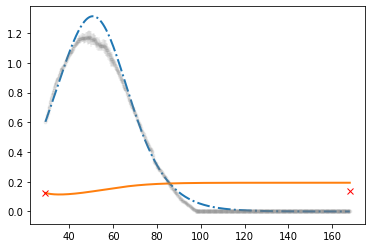

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2108
    # data points      = 557
    # variables        = 5
    chi-square         = 3032.61202
    reduced chi-square = 5.49386235
    Akaike info crit   = 953.900187
    Bayesian info crit = 975.513013
[[Variables]]
    rho:       0.233651 (fixed)
    kappainv:  0.01 (fixed)
    c0:       -0.04359002 +/- 0.00970014 (22.25%) (init = -0.04705747)
    kappac1:   2.32581302 +/- 0.04442178 (1.91%) (init = 2.340221)
    kappac2:   0.01736521 +/- 3.6024e-04 (2.07%) (init = 0.01714034)
    theta:     1.0176e-08 +/- 4.2203e-06 (41473.38%) (init = 1.864808e-07)
    c3:        0.12956637 +/- 0.00334717 (2.58%) (init = 0.1287676)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, kappac2)      =  0.907
    C(kappac1, c3)      =  0.832
    C(theta, c3)        =  0.809
    C(c0, kappac1)      = -0.795
    C(kappac1, theta)   =  0.539
    C(kappac1, kappac2) = -0.502
    C(kappac2, theta)   =  0.387
    C(c0

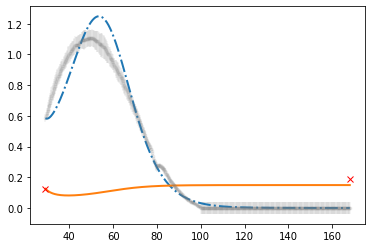

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 215
    # data points      = 557
    # variables        = 5
    chi-square         = 107.672148
    reduced chi-square = 0.19505824
    Akaike info crit   = -905.415182
    Bayesian info crit = -883.802356
[[Variables]]
    rho:       0.233651 (fixed)
    kappainv:  0.01 (fixed)
    c0:       -0.08004371 +/- 0.01456975 (18.20%) (init = -0.03741854)
    kappac1:   1.96690202 +/- 0.12199596 (6.20%) (init = 1.999029)
    kappac2:   0.01051755 +/- 4.4343e-04 (4.22%) (init = 0.01031074)
    theta:     1.0000e-08 +/- 4.3074e-04 (4307323.57%) (init = 1.864808e-07)
    c3:        0.06229210 +/- 0.01263033 (20.28%) (init = 0.06128111)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.998
    C(c0, kappac1)      = -0.990
    C(c0, c3)           = -0.980
    C(kappac2, theta)   = -0.978
    C(c0, kappac2)      =  0.571
    C(c0, theta)        = -0.554
    C(kappac1, theta)   =  0.496
   

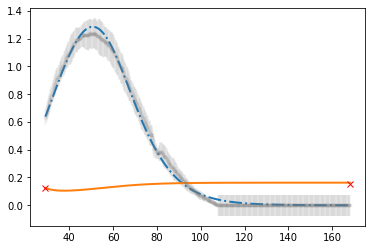

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 324
    # data points      = 557
    # variables        = 5
    chi-square         = 3120.65314
    reduced chi-square = 5.65335713
    Akaike info crit   = 969.840423
    Bayesian info crit = 991.453249
[[Variables]]
    rho:       0.233651 (fixed)
    kappainv:  0.01 (fixed)
    c0:       -0.11783006 +/- 0.04610866 (39.13%) (init = -0.05983272)
    kappac1:   2.06291768 +/- 0.40036704 (19.41%) (init = 1.999029)
    kappac2:   0.00776251 +/- 4.1007e-04 (5.28%) (init = 0.01031074)
    theta:     1.0697e-08 +/- 3.2522e-04 (3040367.98%) (init = 1.864808e-07)
    c3:        0.05343076 +/- 0.04025084 (75.33%) (init = 0.06128111)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  1.000
    C(c0, kappac1)      = -0.999
    C(c0, c3)           = -0.997
    C(kappac2, theta)   =  0.981
    C(c0, theta)        =  0.704
    C(kappac1, theta)   = -0.669
    C(theta, c3)        = -0.657
    

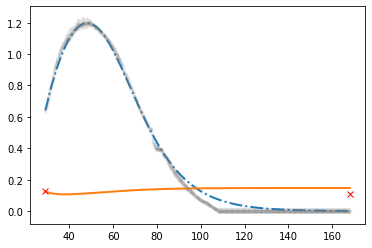

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 557
    # variables        = 5
    chi-square         = 1024.18545
    reduced chi-square = 1.85540843
    Akaike info crit   = 349.261825
    Bayesian info crit = 370.874651
[[Variables]]
    rho:       0.233651 (fixed)
    kappainv:  0.01 (fixed)
    c0:       -0.04834112 +/- 0.00886897 (18.35%) (init = -0.04834112)
    kappac1:   1.45482061 +/- 0.02993930 (2.06%) (init = 1.454821)
    kappac2:   0.00767148 +/- 0.00116646 (15.21%) (init = 0.007671478)
    theta:     1.8648e-07 +/- 0.00124332 (666728.19%) (init = 1.864808e-07)
    c3:        0.00000000 +/- 1.8222e-11 (inf%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.965
    C(kappac1, c3)      =  0.821
    C(c0, kappac1)      = -0.768
    C(kappac2, c3)      =  0.405
    C(c0, c3)           = -0.346
    C(theta, c3)        =  0.346
    C(c0, kappac2)      =  0.328
    C(c0, theta)

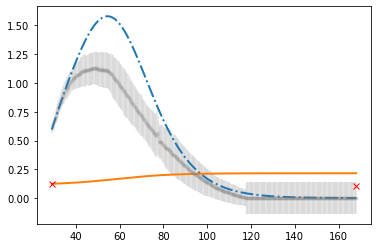

In [91]:
#### #                     T-cell with Dex T cell 2
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_02 = []
#result_dt.pop(2)

count = 5

for i in range(1,2):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_tcell[i].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_tcell[i].params['kappainv'], min=1e-2, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-10, max=10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_02[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_02[j][1], min=lb[count][1], max=ub[count][1], vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=1e-8, max=1e0, vary = True)
        paramsdt.add('c3', value=xopt_dt_02[j][2], min=0, max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_02.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_02[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_02[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_02[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves

#        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')            
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: Swarm best objective change less than 1e-10
[3.82763724 0.00829772 0.04411735] 0.5829963165174946


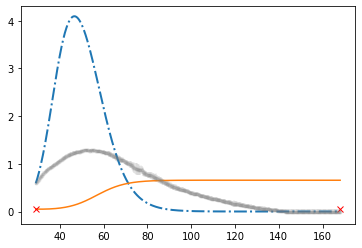

Stopping search: Swarm best objective change less than 1e-10
[3.92518226 0.00913926 0.05690965] 7.002074970851246


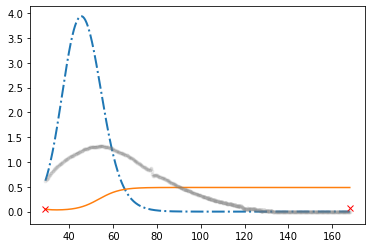

Stopping search: maximum iterations reached --> 200
[11.80135072  0.02161625  0.34097549] 4.111507981625891


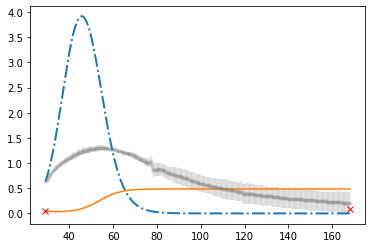

Stopping search: maximum iterations reached --> 200
[ 2.93926846e+00  1.51954913e-03 -4.07316288e-02] 3.253790869811159


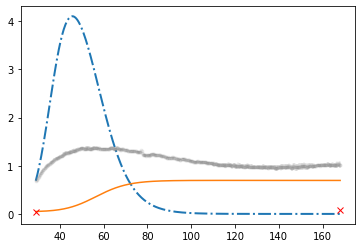

Stopping search: maximum iterations reached --> 200
[11.10561988  0.01313027  0.30352566] 4.0449955612307535


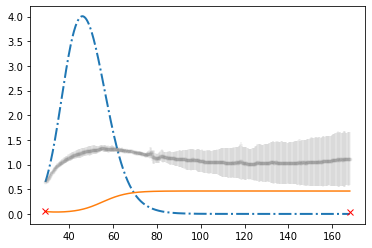

In [92]:
###############################################################################
#                     T-cell with Dex T-cell 3
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_03 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-2, 1e-3, -1e0]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 10
for i in range(2,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=200, minfunc=1e-10, minstep=1e-10, phig=1.7, phip=0.6, swarmsize=100)
        xopt_dt_03.append(xopt_temp)
        print(xopt_dt_03[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')            
#        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [162]:
#xopt_dt_03[0] = xopt_dt_03[4]
#xopt_dt_03[1] = xopt_dt_03[4]
#xopt_dt_03[2] = xopt_dt_03[4]
xopt_dt_03[3] = xopt_dt_03[4]
#print(xopt_dt_03[0])
#print(xopt_dt_03[1])
#print(xopt_dt_03[2])
#print(xopt_dt_03[2])
#print(xopt_dt_03[4])
#xopt_dt_03[3][0] = 10
#xopt_dt_03[3][1] = 0.075
#xopt_dt_03[3][2] = 0.075

#xopt_dt_03[2][0] = 10
#xopt_dt_03[2][1] = 0.075
#xopt_dt_03[2][2] = 0.5

#xopt_dt_03[0][2] = 0.0)
#xopt_dt_03[1][2] = 0.03
#xopt_dt_03[2][2] = 0.03
#xopt_dt_03[3][2] = 0.03
#xopt_dt_03[4][2] = 0.03
#xopt_dt_03
#result_growth_gd[4].params

t_cell_fin_dt

[0.45055,
 0.4802,
 0.3291,
 0.12035,
 0.0647,
 0.14025,
 0.18635,
 0.1558,
 0.10765,
 0.10915,
 0.05495,
 0.08115,
 0.0855,
 0.0917,
 0.0375]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 355
    # data points      = 557
    # variables        = 4
    chi-square         = 186.258699
    reduced chi-square = 0.33681501
    Akaike info crit   = -602.153772
    Bayesian info crit = -584.863512
[[Variables]]
    rho:       0.2410507 (fixed)
    kappainv:  0.1645368 (fixed)
    c0:       -0.05028729 (fixed)
    kappac1:   3.82353027 +/- 0.02656427 (0.69%) (init = 3.827637)
    kappac2:   0.00825700 +/- 1.7236e-04 (2.09%) (init = 0.008297716)
    theta:     1.0001e-08 +/- 1.1524e-04 (1152316.60%) (init = 3.234552e-05)
    c3:        0.04383378 +/- 0.00176098 (4.02%) (init = 0.04411735)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.993
    C(kappac2, theta)   =  0.970
    C(kappac2, c3)      =  0.571
    C(kappac1, kappac2) =  0.534
    C(theta, c3)        =  0.420
    C(kappac1, theta)   =  0.395


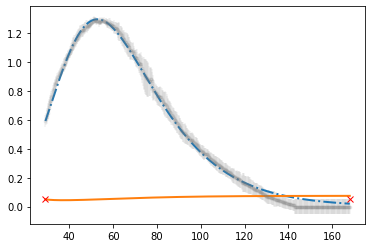

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 557
    # variables        = 4
    chi-square         = 27305.9089
    reduced chi-square = 49.3777738
    Akaike info crit   = 2176.00729
    Bayesian info crit = 2193.29755
[[Variables]]
    rho:       0.2410507 (fixed)
    kappainv:  0.1645368 (fixed)
    c0:       -0.04705747 (fixed)
    kappac1:   3.92516573 +/- 0.00836900 (0.21%) (init = 3.925182)
    kappac2:   0.00913698 +/- 1.3639e-04 (1.49%) (init = 0.00913926)
    theta:     2.8931e-05 +/- 1.6291e-04 (563.08%) (init = 3.234552e-05)
    c3:        0.05691658 +/- 5.6544e-04 (0.99%) (init = 0.05690965)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.992
    C(kappac1, c3)      =  0.964
    C(theta, c3)        = -0.300
    C(kappac1, theta)   = -0.213
    C(kappac2, c3)      = -0.196
    C(kappac1, kappac2) = -0.126


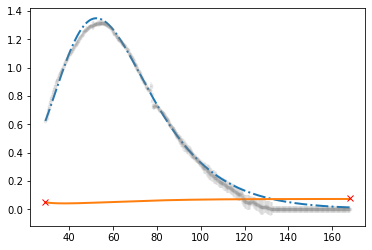

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 344
    # data points      = 557
    # variables        = 4
    chi-square         = 86.0532427
    reduced chi-square = 0.15561165
    Akaike info crit   = -1032.25266
    Bayesian info crit = -1014.96240
[[Variables]]
    rho:       0.2410507 (fixed)
    kappainv:  0.1645368 (fixed)
    c0:       -0.03741854 (fixed)
    kappac1:   3.30406968 +/- 0.01955477 (0.59%) (init = 11.80135)
    kappac2:   0.00651126 +/- 1.5418e-04 (2.37%) (init = 0.02161625)
    theta:     0.00174803 +/- 1.4923e-04 (8.54%) (init = 3.234552e-05)
    c3:       -0.00175260 +/- 0.00144841 (82.64%) (init = 0.3409755)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.996
    C(kappac2, theta)   =  0.968
    C(kappac1, kappac2) =  0.678
    C(kappac2, c3)      =  0.669
    C(kappac1, theta)   =  0.519
    C(theta, c3)        =  0.494


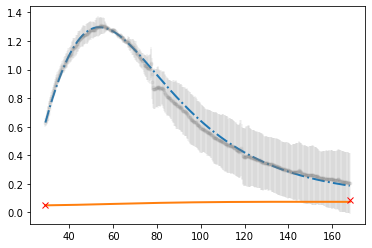

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 557
    # variables        = 4
    chi-square         = 1080.98137
    reduced chi-square = 1.95475835
    Akaike info crit   = 377.324052
    Bayesian info crit = 394.614313
[[Variables]]
    rho:       0.2410507 (fixed)
    kappainv:  0.1645368 (fixed)
    c0:       -0.05983272 (fixed)
    kappac1:   3.56931981 +/- 0.02664751 (0.75%) (init = 2.939268)
    kappac2:   0.00882546 +/- 1.8170e-04 (2.06%) (init = 0.001519549)
    theta:     0.00907063 +/- 2.2651e-04 (2.50%) (init = 3.234552e-05)
    c3:       -0.00106307 +/- 0.00151193 (142.22%) (init = -0.04073163)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.997
    C(kappac1, c3)      =  0.997
    C(kappac1, kappac2) =  0.553
    C(kappac2, c3)      =  0.504
    C(kappac1, theta)   =  0.494
    C(theta, c3)        =  0.442


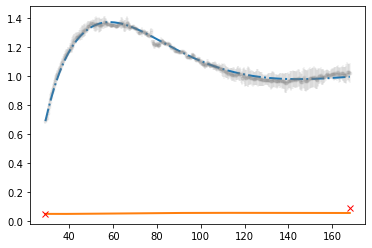

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 475
    # data points      = 557
    # variables        = 4
    chi-square         = 51.9307970
    reduced chi-square = 0.09390741
    Akaike info crit   = -1313.56785
    Bayesian info crit = -1296.27759
[[Variables]]
    rho:       0.2410507 (fixed)
    kappainv:  0.1645368 (fixed)
    c0:       -0.04834112 (fixed)
    kappac1:   3.14608688 +/- 0.01570333 (0.50%) (init = 11.10562)
    kappac2:   0.01459894 +/- 4.8040e-04 (3.29%) (init = 0.01313027)
    theta:     0.01580630 +/- 5.9298e-04 (3.75%) (init = 3.234552e-05)
    c3:       -0.03349592 +/- 0.00112190 (3.35%) (init = 0.3035257)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.997
    C(kappac1, c3)      =  0.943
    C(kappac1, kappac2) =  0.438
    C(kappac1, theta)   =  0.386
    C(kappac2, c3)      =  0.202
    C(theta, c3)        =  0.135


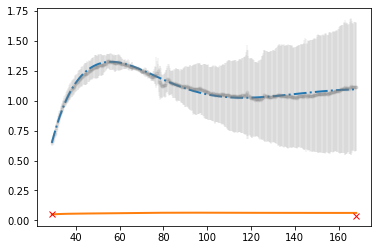

In [93]:
###############################################################################
#                     T-cell with Dex T cell 3
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_03 = []
#result_dt.pop(2)

count = 10

new_c0 = np.array([-0.48, -0.35, -0.1199, -0.277, -0.263])

for i in range(2,3):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 666:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)
        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_tcell[i].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_tcell[i].params['kappainv'], min=0.01, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min = -1e0, max = 1e0, vary = False)
#        paramsdt.add('c0', value=-0.15, min=-10, max=-1e-10, vary = True)
#        paramsdt.add('c0', value=new_c0[j], min=-10, max=-1e-10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_03[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_03[j][1], min=1e-4, max=0.1, vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=1e-8, max=1e0, vary = True)
        paramsdt.add('c3', value=xopt_dt_03[j][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_03.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_03[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_03[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_03[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    
#        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

In [94]:
###############################################################################
#             Write to file the output from the fit procedures.
#         Do this in two steps, assuming the file already exists
#         First: write the values from the zero t-cell fit.
#         Second: write the values from the t-cell fit as we loop through each dex
#         treatment.
###############################################################################

with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
    ## Need nother single line report, one for growth without dex or t cell
    ## and one for interaction without dex
    
    fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    ## This block will remain on its own as we write the zero t cell zero dex fit.
    fit_report_writer.writerow([tumor_line, data_column_0, start_0, end_0, dex_0, t_cell_start_0, t_cell_start_0, 
                                result_growth.chisqr, result_growth.redchi,
                                result_growth.params['rho'].value, result_growth.params['rho'].stderr, 
                                result_growth.params['kappainv'].value, result_growth.params['kappainv'].stderr, 
                                result_growth.params['c0'].value, result_growth.params['c0'].stderr, 
                                result_growth.params['kappac1'].value, result_growth.params['kappac1'].stderr, 
                                result_growth.params['kappac2'].value, result_growth.params['kappac2'].stderr,
                                result_growth.params['theta'].value, result_growth.params['theta'].stderr, 
                                result_growth.params['c3'].value, result_growth.params['c3'].stderr])    
    
## This block will remain on its own as we write the zero dex fit.    
## Need a for loop as we have to loop through each trial for this scenario.
for i in range(0,3):
    with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    
        fit_report_writer.writerow([tumor_line, data_column_t[i], start_t[i], end_t[i], dex_start_t[i], 
                                    t_cell_start_t[i], t_fin_vec[i],
                                    result_tcell[i].chisqr, result_tcell[i].redchi,
                                    result_tcell[i].params['rho'].value, result_tcell[i].params['rho'].stderr, 
                                    result_tcell[i].params['kappainv'].value, result_tcell[i].params['kappainv'].stderr, 
                                    result_tcell[i].params['c0'].value, result_tcell[i].params['c0'].stderr, 
                                    result_tcell[i].params['kappac1'].value, result_tcell[i].params['kappac1'].stderr, 
                                    result_tcell[i].params['kappac2'].value, result_tcell[i].params['kappac2'].stderr,
                                    result_tcell[i].params['theta'].value, result_tcell[i].params['theta'].stderr, 
                                    result_tcell[i].params['c3'].value, result_tcell[i].params['c3'].stderr])

    
## Need another loop, one for growths without t cells but with dex
## and one for interactions with dex and without t cells.
for i in range(0,5):  
    with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_gd[i], start_gd[i], end_gd[i], dex_start_gd[i],
                                    t_cell_start_gd[i], t_cell_start_gd[i],
                                    result_growth_gd[i].chisqr, result_growth_gd[i].redchi, 
                                    result_growth_gd[i].params['rho'].value, result_growth_gd[i].params['rho'].stderr,
                                    result_growth_gd[i].params['kappainv'].value, result_growth_gd[i].params['kappainv'].stderr,
                                    result_growth_gd[i].params['c0'].value, result_growth_gd[i].params['c0'].stderr,
                                    result_growth_gd[i].params['kappac1'].value, result_growth_gd[i].params['kappac1'].stderr,
                                    result_growth_gd[i].params['kappac2'].value, result_growth_gd[i].params['kappac2'].stderr, 
                                    result_growth_gd[i].params['theta'].value, result_growth_gd[i].params['theta'].stderr,
                                    result_growth_gd[i].params['c3'].value, result_growth_gd[i].params['c3'].stderr])

count = 0
i = 0
for j in range(0,5):
    with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_01[j].chisqr, result_dt_01[j].redchi, 
                                    result_dt_01[j].params['rho'].value, result_dt_01[j].params['rho'].stderr,
                                    result_dt_01[j].params['kappainv'].value, result_dt_01[j].params['kappainv'].stderr,
                                    result_dt_01[j].params['c0'].value, result_dt_01[j].params['c0'].stderr,
                                    result_dt_01[j].params['kappac1'].value, result_dt_01[j].params['kappac1'].stderr,
                                    result_dt_01[j].params['kappac2'].value, result_dt_01[j].params['kappac2'].stderr, 
                                    result_dt_01[j].params['theta'].value, result_dt_01[j].params['theta'].stderr,
                                    result_dt_01[j].params['c3'].value, result_dt_01[j].params['c3'].stderr])
        count = count + 1

count = 5
i = 1
for j in range(0,5):
    with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_02[j].chisqr, result_dt_02[j].redchi, 
                                    result_dt_02[j].params['rho'].value, result_dt_02[j].params['rho'].stderr,
                                    result_dt_02[j].params['kappainv'].value, result_dt_02[j].params['kappainv'].stderr,
                                    result_dt_02[j].params['c0'].value, result_dt_02[j].params['c0'].stderr,
                                    result_dt_02[j].params['kappac1'].value, result_dt_02[j].params['kappac1'].stderr,
                                    result_dt_02[j].params['kappac2'].value, result_dt_02[j].params['kappac2'].stderr, 
                                    result_dt_02[j].params['theta'].value, result_dt_02[j].params['theta'].stderr,
                                    result_dt_02[j].params['c3'].value, result_dt_02[j].params['c3'].stderr])
        count = count + 1

count = 10
i = 2
for j in range(0,5):
    with open('./third_round_exports/pbt4_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j],
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_03[j].chisqr, result_dt_03[j].redchi, 
                                    result_dt_03[j].params['rho'].value, result_dt_03[j].params['rho'].stderr,
                                    result_dt_03[j].params['kappainv'].value, result_dt_03[j].params['kappainv'].stderr,
                                    result_dt_03[j].params['c0'].value, result_dt_03[j].params['c0'].stderr,
                                    result_dt_03[j].params['kappac1'].value, result_dt_03[j].params['kappac1'].stderr,
                                    result_dt_03[j].params['kappac2'].value, result_dt_03[j].params['kappac2'].stderr, 
                                    result_dt_03[j].params['theta'].value, result_dt_03[j].params['theta'].stderr,
                                    result_dt_03[j].params['c3'].value, result_dt_03[j].params['c3'].stderr])
        count = count + 1

